In [1]:
import dspy
import os
import sqlite3
import pandas as pd
import random
import json
from datasets import load_dataset
import matplotlib.pyplot as plt  # reward 그래프 용

# ----------------------------------------
# 1. Configuration
# ----------------------------------------
DB_ROOT = "/home/pj/NLP Project/dev_databases"
MODEL_NAME = "Qwen/Qwen3-Next-80B-A3B-Instruct"
BASE_URL = "http://211.47.56.81:7972/v1"
API_KEY = "token-abc123"

lm = dspy.LM(
    model="openai/" + MODEL_NAME,
    api_base=BASE_URL,
    api_key=API_KEY,
    temperature=0.0
)

dspy.configure(lm=lm)


/home/pj/NLP Project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ----------------------------------------
# 2. Helper Functions (Schema & Execution)
# ----------------------------------------
def execute_sql(db_path, sql):
    try:
        conn = sqlite3.connect(db_path)
        cur = conn.cursor()
        cur.execute(sql)
        result = cur.fetchall()
        conn.close()
        return result
    except Exception as e:
        return f"ERROR: {e}"

def load_schema_from_csv(db_dir):
    schema = {"tables": {}}
    schema_csv_dir = os.path.join(db_dir, "database_description")
    if not os.path.exists(schema_csv_dir):
        return schema

    for file in os.listdir(schema_csv_dir):
        if file.endswith(".csv"):
            table_name = file.replace(".csv", "")
            csv_path = os.path.join(schema_csv_dir, file)
            
            df = None
            for encoding in ["utf-8", "cp1252", "latin1"]:
                try:
                    df = pd.read_csv(csv_path, sep=None, engine="python", encoding=encoding)
                    break
                except UnicodeDecodeError:
                    continue
            
            if df is None:
                continue

            cols = ["original_column_name", "column_description", "data_format", "value_description"]
            for c in cols:
                if c not in df.columns:
                    df[c] = ""
            records = df[cols].to_dict(orient="records")
            schema["tables"][table_name] = records
    return schema

def format_schema(schema):
    return json.dumps(schema, indent=2)

In [3]:
# ----------------------------------------
# 3. Load Dataset & Prepare DSPy Examples
# ----------------------------------------
dataset = load_dataset("birdsql/bird_sql_dev_20251106")["dev_20251106"]
challenging_ds = dataset.filter(lambda x: x["difficulty"] == "challenging")

full_list = list(challenging_ds)
random.seed(42)
random.shuffle(full_list)

split_idx = int(len(full_list) * 0.8)
train_raw = full_list[:split_idx]
test_raw = full_list[split_idx:]

print(f"Train Size: {len(train_raw)}, Test Size: {len(test_raw)}")

def create_dspy_examples(raw_data):
    examples = []
    for item in raw_data:
        db_id = item['db_id']
        db_dir = f"{DB_ROOT}/{db_id}"
        schema = load_schema_from_csv(db_dir)
        schema_text = format_schema(schema)
        
        ex = dspy.Example(
            question=item['question'],
            schema=schema_text,
            sql=item['SQL'],
            db_id=db_id
        ).with_inputs('question', 'schema')
        examples.append(ex)
    return examples

train_examples = create_dspy_examples(train_raw[:])
test_examples = create_dspy_examples(test_raw[:])


Train Size: 184, Test Size: 47


In [4]:
# ----------------------------------------
# 5. Custom Metric (Execution Match)
# ----------------------------------------
def sql_execution_metric(example, pred, trace=None):
    pred_sql = pred.sql.strip().replace("```sql", "").replace("```", "").strip()
    
    db_id = example.db_id
    db_path = f"{DB_ROOT}/{db_id}/{db_id}.sqlite"
    
    pred_res = execute_sql(db_path, pred_sql)
    gold_res = execute_sql(db_path, example.sql)
    
    return str(pred_res) == str(gold_res)


class TextToSQL(dspy.Signature):
    # docstring(=instructions)에 initial_prompt를 그대로 집어넣음
    """You are a Text-to-SQL model.
    Given the database schema and a natural language question,
    generate a valid SQLite SQL query.
    Return only the SQL query.
    """
    schema = dspy.InputField(desc="The database schema")
    question = dspy.InputField(desc="The natural language question")
    sql = dspy.OutputField(desc="The corresponding SQL query")

# 위처럼 docstring에 initial_prompt를 박았기 때문에,
# DSPy는 이걸 내부적으로 instruction으로 사용함.
module = dspy.ChainOfThought(TextToSQL)

/home/pj/NLP Project/.venv/lib/python3.12/site-packages/dspy/signatures/signature.py:154: UserWarning: Field name "schema" in "TextToSQL" shadows an attribute in parent "Signature"
  cls = super().__new__(mcs, signature_name, bases, namespace, **kwargs)
/home/pj/NLP Project/.venv/lib/python3.12/site-packages/dspy/signatures/signature.py:154: UserWarning: Field name "schema" in "StringSignature" shadows an attribute in parent "Signature"
  cls = super().__new__(mcs, signature_name, bases, namespace, **kwargs)


2025/12/01 19:43:09 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 1: BOOTSTRAP FEWSHOT EXAMPLES <==
2025/12/01 19:43:09 INFO dspy.teleprompt.mipro_optimizer_v2: These will be used as few-shot example candidates for our program and for creating instructions.

2025/12/01 19:43:09 INFO dspy.teleprompt.mipro_optimizer_v2: Bootstrapping N=4 sets of demonstrations...


Bootstrapping set 1/4
Bootstrapping set 2/4
Bootstrapping set 3/4


 30%|██▉       | 45/152 [00:19<00:47,  2.27it/s]


Bootstrapped 4 full traces after 45 examples for up to 1 rounds, amounting to 45 attempts.
Bootstrapping set 4/4


 11%|█         | 17/152 [00:02<00:17,  7.66it/s]
2025/12/01 19:43:31 INFO dspy.teleprompt.mipro_optimizer_v2: 
==> STEP 2: PROPOSE INSTRUCTION CANDIDATES <==
2025/12/01 19:43:31 INFO dspy.teleprompt.mipro_optimizer_v2: We will use the few-shot examples from the previous step, a generated dataset summary, a summary of the program code, and a randomly selected prompting tip to propose instructions.
2025/12/01 19:43:31 INFO dspy.teleprompt.mipro_optimizer_v2: 
Proposing N=4 instructions...



Bootstrapped 3 full traces after 17 examples for up to 1 rounds, amounting to 17 attempts.
SOURCE CODE: StringSignature(schema, question -> reasoning, sql
    instructions='You are a Text-to-SQL model.\nGiven the database schema and a natural language question,\ngenerate a valid SQLite SQL query.\nReturn only the SQL query.'
    schema = Field(annotation=str required=True json_schema_extra={'desc': 'The database schema', '__dspy_field_type': 'input', 'prefix': 'Schema:'})
    question = Field(annotation=str required=True json_schema_extra={'desc': 'The natural language question', '__dspy_field_type': 'input', 'prefix': 'Question:'})
    reasoning = Field(annotation=str required=True json_schema_extra={'prefix': "Reasoning: Let's think step by step in order to", 'desc': '${reasoning}', '__dspy_field_type': 'output'})
    sql = Field(annotation=str required=True json_schema_extra={'desc': 'The corresponding SQL query', '__dspy_field_type': 'output', 'prefix': 'Sql:'})
)




DATA SUMMARY:

2025/12/01 19:43:31 INFO dspy.teleprompt.mipro_optimizer_v2: Proposed Instructions for Predictor 0:

2025/12/01 19:43:31 INFO dspy.teleprompt.mipro_optimizer_v2: 0: You are a Text-to-SQL model.
Given the database schema and a natural language question,
generate a valid SQLite SQL query.
Return only the SQL query.

2025/12/01 19:43:31 INFO dspy.teleprompt.mipro_optimizer_v2: 1: You are a Text-to-SQL expert. Given a database schema with detailed column descriptions and commonsense reasoning hints, and a natural language question requiring multi-hop reasoning, first generate a clear, step-by-step reasoning trace that maps the question to the correct tables, joins, filters, and aggregations. Then, produce a valid, production-grade SQLite query that exactly matches the reasoning — handling nulls, type casting, and explicit ordering where needed. Return the reasoning prefixed with "Reasoning:" and the SQL query prefixed with "Sql:", with no additional text.

2025/12/01 19:43:31 INFO dspy.tel

task_demos Schema: {
  "tables": {
    "molecule": [
      {
        "original_column_name": "molecule_id",
        "column_description": "unique id of molecule",
        "data_format": "text",
        "value_description": "\"+\" --> this molecule / compound is carcinogenic\n'-' this molecule is not / compound carcinogenic"
      },
      {
        "original_column_name": "label",
        "column_description": "whether this molecule is carcinogenic or not",
        "data_format": "text",
        "value_description": NaN
      }
    ],
    "connected": [
      {
        "original_column_name": "atom_id",
        "column_description": "id of the first atom",
        "data_format": "text",
        "value_description": NaN
      },
      {
        "original_column_name": "atom_id2",
        "column_description": "id of the second atom",
        "data_format": "text",
        "value_description": NaN
      },
      {
        "original_column_name": "bond_id",
        "column_description": "

2025/12/01 19:43:34 INFO dspy.evaluate.evaluate: Average Metric: 3 / 32 (9.4%)
2025/12/01 19:43:34 INFO dspy.teleprompt.mipro_optimizer_v2: Default program score: 9.38

/home/pj/NLP Project/.venv/lib/python3.12/site-packages/optuna/_experimental.py:32: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
2025/12/01 19:43:34 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 2 / 37 - Minibatch ==
2025/12/01 19:43:34 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a Text-to-SQL expert. Given a database schema with detailed column descriptions and commonsense reasoning hints, and a natural language question requiring multi-hop reasoning, first generate a clear, step-by-step reasoning trace that maps the question to the correct tables, joins, filters, and aggregations. Then, produce a valid, production-grade SQLite query that exactly matches the reasoning — handling nulls, type casting, and explicit ordering where needed. Return the reasoning prefixed with "Reasoning:" and the SQL query prefixed with "Sql:", with no additional text.
p: Sql:


Average Metric: 3.00 / 32 (9.4%): 100%|██████████| 32/32 [00:01<00:00, 17.47it/s] 

2025/12/01 19:43:36 INFO dspy.evaluate.evaluate: Average Metric: 3 / 32 (9.4%)
2025/12/01 19:43:36 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 9.38 on minibatch of size 32 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 2'].
2025/12/01 19:43:36 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:43:36 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38]
2025/12/01 19:43:36 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 9.38
2025/12/01 19:43:36 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/12/01 19:43:36 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 3 / 37 - Minibatch ==
2025/12/01 19:43:36 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a Text-to-SQL model. Given a database schema and a natural language question, first reason step by step about which tables to join, what conditions to apply, and how to structure the query to correctly answer the question. Then, output a valid SQLite SQL query that exactly matches the intent of the question. Return only the SQL query after your reasoning.
p: Sql:


Average Metric: 4.00 / 32 (12.5%): 100%|██████████| 32/32 [00:01<00:00, 17.94it/s]

2025/12/01 19:43:37 INFO dspy.evaluate.evaluate: Average Metric: 4 / 32 (12.5%)
2025/12/01 19:43:37 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 12.5 on minibatch of size 32 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 0'].
2025/12/01 19:43:37 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:43:37 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5]
2025/12/01 19:43:37 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 9.38
2025/12/01 19:43:37 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/12/01 19:43:37 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 4 / 37 - Minibatch ==
2025/12/01 19:43:37 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a Text-to-SQL model.
Given the database schema and a natural language question,
generate a valid SQLite SQL query.
Return only the SQL query.
p: Sql:


Average Metric: 4.00 / 32 (12.5%): 100%|██████████| 32/32 [00:01<00:00, 18.82it/s]

2025/12/01 19:43:39 INFO dspy.evaluate.evaluate: Average Metric: 4 / 32 (12.5%)
2025/12/01 19:43:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 12.5 on minibatch of size 32 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 2'].
2025/12/01 19:43:39 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:43:39 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5]
2025/12/01 19:43:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 9.38
2025/12/01 19:43:39 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/12/01 19:43:39 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 5 / 37 - Minibatch ==
2025/12/01 19:43:39 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
p: Sql:


Average Metric: 4.00 / 32 (12.5%): 100%|██████████| 32/32 [00:01<00:00, 17.47it/s]

2025/12/01 19:43:41 INFO dspy.evaluate.evaluate: Average Metric: 4 / 32 (12.5%)
2025/12/01 19:43:41 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 12.5 on minibatch of size 32 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 1'].
2025/12/01 19:43:41 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:43:41 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5]
2025/12/01 19:43:41 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 9.38
2025/12/01 19:43:41 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/12/01 19:43:41 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 6 / 37 - Minibatch ==
2025/12/01 19:43:41 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a Text-to-SQL model.
Given the database schema and a natural language question,
generate a valid SQLite SQL query.
Return only the SQL query.
p: Sql:


Average Metric: 3.00 / 32 (9.4%): 100%|██████████| 32/32 [00:01<00:00, 18.41it/s]  

2025/12/01 19:43:43 INFO dspy.evaluate.evaluate: Average Metric: 3 / 32 (9.4%)
2025/12/01 19:43:43 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 9.38 on minibatch of size 32 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 0'].
2025/12/01 19:43:43 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:43:43 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38]
2025/12/01 19:43:43 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 9.38
2025/12/01 19:43:43 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/12/01 19:43:43 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 7 / 37 - Full Evaluation =====
2025/12/01 19:43:43 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 12.5) from minibatch trials...



Average Metric: 4.00 / 32 (12.5%): 100%|██████████| 32/32 [00:01<00:00, 17.48it/s]

2025/12/01 19:43:45 INFO dspy.evaluate.evaluate: Average Metric: 4 / 32 (12.5%)
2025/12/01 19:43:45 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 12.5
2025/12/01 19:43:45 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5]
2025/12/01 19:43:45 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 12.5
2025/12/01 19:43:45 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/12/01 19:43:45 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/12/01 19:43:45 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 8 / 37 - Minibatch ==
2025/12/01 19:43:45 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a Text-to-SQL model.
Given the database schema and a natural language question,
generate a valid SQLite SQL query.
Return only the SQL query.
p: Sql:


Average Metric: 3.00 / 32 (9.4%): 100%|██████████| 32/32 [00:01<00:00, 17.64it/s] 

2025/12/01 19:43:47 INFO dspy.evaluate.evaluate: Average Metric: 3 / 32 (9.4%)
2025/12/01 19:43:47 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 9.38 on minibatch of size 32 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 0'].
2025/12/01 19:43:47 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:43:47 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38]
2025/12/01 19:43:47 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 12.5
2025/12/01 19:43:47 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/12/01 19:43:47 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 9 / 37 - Minibatch ==
2025/12/01 19:43:47 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a Text-to-SQL model.
Given the database schema and a natural language question,
generate a valid SQLite SQL query.
Return only the SQL query.
p: Sql:


Average Metric: 3.00 / 32 (9.4%): 100%|██████████| 32/32 [00:02<00:00, 10.95it/s]  

2025/12/01 19:43:50 INFO dspy.evaluate.evaluate: Average Metric: 3 / 32 (9.4%)
2025/12/01 19:43:50 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 9.38 on minibatch of size 32 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 0'].
2025/12/01 19:43:50 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:43:50 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38]
2025/12/01 19:43:50 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 12.5
2025/12/01 19:43:50 INFO dspy.teleprompt.mipro_optimizer_v2: =========================================


2025/12/01 19:43:50 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 10 / 37 - Minibatch ==
2025/12/01 19:43:50 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a Text-to-SQL model.
Given the database schema and a natural language question,
generate a valid SQLite SQL query.
Return only the SQL query.
p: Sql:


Average Metric: 4.00 / 32 (12.5%): 100%|██████████| 32/32 [00:01<00:00, 18.60it/s] 

2025/12/01 19:43:51 INFO dspy.evaluate.evaluate: Average Metric: 4 / 32 (12.5%)
2025/12/01 19:43:51 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 12.5 on minibatch of size 32 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 2'].
2025/12/01 19:43:51 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:43:51 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5]
2025/12/01 19:43:51 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 12.5
2025/12/01 19:43:51 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:43:51 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 11 / 37 - Minibatch ==
2025/12/01 19:43:51 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a Text-to-SQL model. Given a database schema and a natural language question, first reason step by step about which tables to join, what conditions to apply, and how to structure the query to correctly answer the question. Then, output a valid SQLite SQL query that exactly matches the intent of the question. Return only the SQL query after your reasoning.
p: Sql:


Average Metric: 4.00 / 32 (12.5%): 100%|██████████| 32/32 [00:01<00:00, 18.68it/s] 

2025/12/01 19:43:53 INFO dspy.evaluate.evaluate: Average Metric: 4 / 32 (12.5%)
2025/12/01 19:43:53 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 12.5 on minibatch of size 32 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 0'].
2025/12/01 19:43:53 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:43:53 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5]
2025/12/01 19:43:53 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 12.5
2025/12/01 19:43:53 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:43:53 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 12 / 37 - Minibatch ==
2025/12/01 19:43:53 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a Text-to-SQL model. Given a database schema and a natural language question, first reason step by step about which tables to join, what conditions to apply, and how to structure the query to correctly answer the question. Then, output a valid SQLite SQL query that exactly matches the intent of the question. Return only the SQL query after your reasoning.
p: Sql:


Average Metric: 4.00 / 32 (12.5%): 100%|██████████| 32/32 [00:01<00:00, 20.59it/s]

2025/12/01 19:43:55 INFO dspy.evaluate.evaluate: Average Metric: 4 / 32 (12.5%)
2025/12/01 19:43:55 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 12.5 on minibatch of size 32 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 2'].
2025/12/01 19:43:55 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []


2025/12/01 19:43:55 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5]
2025/12/01 19:43:55 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 12.5
2025/12/01 19:43:55 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:43:55 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 13 / 37 - Full Evaluation =====
2025/12/01 19:43:55 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 12.5) from minibatch trials...


Average Metric: 4.00 / 32 (12.5%): 100%|██████████| 32/32 [00:01<00:00, 19.61it/s] 

2025/12/01 19:43:56 INFO dspy.evaluate.evaluate: Average Metric: 4 / 32 (12.5%)
2025/12/01 19:43:56 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5]
2025/12/01 19:43:56 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 12.5
2025/12/01 19:43:56 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/12/01 19:43:56 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/12/01 19:43:56 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 14 / 37 - Minibatch ==
2025/12/01 19:43:56 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a Text-to-SQL model. Given a database schema and a natural language question, first reason step by step about which tables to join, what conditions to apply, and how to structure the query to correctly answer the question. Then, output a valid SQLite SQL query that exactly matches the intent of the question. Return only the SQL query after your reasoning.
p: Sql:


Average Metric: 2.00 / 32 (6.2%): 100%|██████████| 32/32 [00:01<00:00, 16.98it/s] 

2025/12/01 19:43:58 INFO dspy.evaluate.evaluate: Average Metric: 2 / 32 (6.2%)
2025/12/01 19:43:58 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 6.25 on minibatch of size 32 with parameters ['Predictor 0: Instruction 3', 'Predictor 0: Few-Shot Set 1'].
2025/12/01 19:43:58 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:43:58 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25]
2025/12/01 19:43:58 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 12.5
2025/12/01 19:43:58 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:43:58 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 15 / 37 - Minibatch ==
2025/12/01 19:43:58 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
p: Sql:


Average Metric: 6.00 / 32 (18.8%): 100%|██████████| 32/32 [00:01<00:00, 18.17it/s]

2025/12/01 19:44:00 INFO dspy.evaluate.evaluate: Average Metric: 6 / 32 (18.8%)
2025/12/01 19:44:00 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 18.75 on minibatch of size 32 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/12/01 19:44:00 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:00 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75]
2025/12/01 19:44:00 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 12.5
2025/12/01 19:44:00 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:00 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 16 / 37 - Minibatch ==
2025/12/01 19:44:00 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
p: Sql:


Average Metric: 6.00 / 32 (18.8%): 100%|██████████| 32/32 [00:01<00:00, 20.24it/s] 

2025/12/01 19:44:02 INFO dspy.evaluate.evaluate: Average Metric: 6 / 32 (18.8%)
2025/12/01 19:44:02 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 18.75 on minibatch of size 32 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/12/01 19:44:02 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:02 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75]
2025/12/01 19:44:02 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 12.5
2025/12/01 19:44:02 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:02 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 17 / 37 - Minibatch ==
2025/12/01 19:44:02 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
p: Sql:


Average Metric: 6.00 / 32 (18.8%): 100%|██████████| 32/32 [00:01<00:00, 19.14it/s]

2025/12/01 19:44:03 INFO dspy.evaluate.evaluate: Average Metric: 6 / 32 (18.8%)
2025/12/01 19:44:03 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 18.75 on minibatch of size 32 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/12/01 19:44:03 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:03 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75]
2025/12/01 19:44:03 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 12.5
2025/12/01 19:44:03 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:03 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 18 / 37 - Minibatch ==
2025/12/01 19:44:03 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
p: Sql:


Average Metric: 5.00 / 32 (15.6%): 100%|██████████| 32/32 [00:01<00:00, 16.23it/s]

2025/12/01 19:44:05 INFO dspy.evaluate.evaluate: Average Metric: 5 / 32 (15.6%)
2025/12/01 19:44:05 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 15.62 on minibatch of size 32 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 3'].
2025/12/01 19:44:05 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:05 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62]
2025/12/01 19:44:05 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 12.5
2025/12/01 19:44:05 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:05 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 19 / 37 - Full Evaluation =====
2025/12/01 19:44:05 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg Score: 18.75) from minibatch trials...



Average Metric: 6.00 / 32 (18.8%): 100%|██████████| 32/32 [00:01<00:00, 17.88it/s] 

2025/12/01 19:44:07 INFO dspy.evaluate.evaluate: Average Metric: 6 / 32 (18.8%)
2025/12/01 19:44:07 INFO dspy.teleprompt.mipro_optimizer_v2: New best full eval score! Score: 18.75
2025/12/01 19:44:07 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75]
2025/12/01 19:44:07 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:07 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/12/01 19:44:07 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/12/01 19:44:07 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 20 / 37 - Minibatch ==
2025/12/01 19:44:07 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a Text-to-SQL expert. Given a database schema with detailed column descriptions and commonsense reasoning hints, and a natural language question requiring multi-hop reasoning, first generate a clear, step-by-step reasoning trace that maps the question to the correct tables, joins, filters, and aggregations. Then, produce a valid, production-grade SQLite query that exactly matches the reasoning — handling nulls, type casting, and explicit ordering where needed. Return the reasoning prefixed with "Reasoning:" and the SQL query prefixed with "Sql:", with no additional text.
p: Sql:


Average Metric: 5.00 / 32 (15.6%): 100%|██████████| 32/32 [00:01<00:00, 17.06it/s]

2025/12/01 19:44:09 INFO dspy.evaluate.evaluate: Average Metric: 5 / 32 (15.6%)
2025/12/01 19:44:09 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 15.62 on minibatch of size 32 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 3'].
2025/12/01 19:44:09 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:09 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62]
2025/12/01 19:44:09 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:09 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:09 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 21 / 37 - Minibatch ==
2025/12/01 19:44:09 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
p: Sql:


Average Metric: 2.00 / 32 (6.2%): 100%|██████████| 32/32 [00:01<00:00, 17.27it/s] 

2025/12/01 19:44:11 INFO dspy.evaluate.evaluate: Average Metric: 2 / 32 (6.2%)
2025/12/01 19:44:11 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 6.25 on minibatch of size 32 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 0'].
2025/12/01 19:44:11 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:11 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25]
2025/12/01 19:44:11 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:11 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:11 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 22 / 37 - Minibatch ==
2025/12/01 19:44:11 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
p: Sql:


Average Metric: 6.00 / 32 (18.8%): 100%|██████████| 32/32 [00:01<00:00, 16.77it/s] 

2025/12/01 19:44:13 INFO dspy.evaluate.evaluate: Average Metric: 6 / 32 (18.8%)
2025/12/01 19:44:13 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 18.75 on minibatch of size 32 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/12/01 19:44:13 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:13 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75]
2025/12/01 19:44:13 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:13 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:13 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 23 / 37 - Minibatch ==
2025/12/01 19:44:13 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
p: Sql:


Average Metric: 6.00 / 32 (18.8%): 100%|██████████| 32/32 [00:01<00:00, 16.92it/s] 

2025/12/01 19:44:15 INFO dspy.evaluate.evaluate: Average Metric: 6 / 32 (18.8%)
2025/12/01 19:44:15 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 18.75 on minibatch of size 32 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/12/01 19:44:15 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:15 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75, 18.75]
2025/12/01 19:44:15 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:15 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:15 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 24 / 37 - Minibatch ==
2025/12/01 19:44:15 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a Text-to-SQL expert. Given a database schema with detailed column descriptions and commonsense reasoning hints, and a natural language question requiring multi-hop reasoning, first generate a clear, step-by-step reasoning trace that maps the question to the correct tables, joins, filters, and aggregations. Then, produce a valid, production-grade SQLite query that exactly matches the reasoning — handling nulls, type casting, and explicit ordering where needed. Return the reasoning prefixed with "Reasoning:" and the SQL query prefixed with "Sql:", with no additional text.
p: Sql:


Average Metric: 5.00 / 32 (15.6%): 100%|██████████| 32/32 [00:01<00:00, 16.93it/s]

2025/12/01 19:44:17 INFO dspy.evaluate.evaluate: Average Metric: 5 / 32 (15.6%)
2025/12/01 19:44:17 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 15.62 on minibatch of size 32 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 1'].
2025/12/01 19:44:17 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:17 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75, 18.75, 15.62]
2025/12/01 19:44:17 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:17 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:17 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 25 / 37 - Full Evaluation =====
2025/12/01 19:44:17 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full eval on next top averaging program (Avg 


Average Metric: 5.00 / 32 (15.6%): 100%|██████████| 32/32 [00:01<00:00, 17.34it/s] 

2025/12/01 19:44:19 INFO dspy.evaluate.evaluate: Average Metric: 5 / 32 (15.6%)
2025/12/01 19:44:19 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75, 18.75, 15.62, 15.62]
2025/12/01 19:44:19 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:19 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/12/01 19:44:19 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/12/01 19:44:19 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 26 / 37 - Minibatch ==
2025/12/01 19:44:19 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
p: Sql:


Average Metric: 6.00 / 32 (18.8%): 100%|██████████| 32/32 [00:03<00:00, 10.36it/s] 

2025/12/01 19:44:22 INFO dspy.evaluate.evaluate: Average Metric: 6 / 32 (18.8%)
2025/12/01 19:44:22 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 18.75 on minibatch of size 32 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/12/01 19:44:22 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:22 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75, 18.75, 15.62, 15.62, 18.75]
2025/12/01 19:44:22 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:22 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:22 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 27 / 37 - Minibatch ==
2025/12/01 19:44:22 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
p: Sql:


Average Metric: 6.00 / 32 (18.8%): 100%|██████████| 32/32 [00:01<00:00, 16.95it/s] 

2025/12/01 19:44:24 INFO dspy.evaluate.evaluate: Average Metric: 6 / 32 (18.8%)
2025/12/01 19:44:24 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 18.75 on minibatch of size 32 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/12/01 19:44:24 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:24 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75, 18.75, 15.62, 15.62, 18.75, 18.75]
2025/12/01 19:44:24 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:24 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:24 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 28 / 37 - Minibatch ==
2025/12/01 19:44:24 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program


Predictor 0
i: You are a Text-to-SQL model.
Given the database schema and a natural language question,
generate a valid SQLite SQL query.
Return only the SQL query.
p: Sql:


Average Metric: 5.00 / 32 (15.6%): 100%|██████████| 32/32 [00:01<00:00, 17.72it/s]

2025/12/01 19:44:26 INFO dspy.evaluate.evaluate: Average Metric: 5 / 32 (15.6%)
2025/12/01 19:44:26 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 15.62 on minibatch of size 32 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 1'].
2025/12/01 19:44:26 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:26 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75, 18.75, 15.62, 15.62, 18.75, 18.75, 15.62]
2025/12/01 19:44:26 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:26 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:26 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 29 / 37 - Minibatch ==
2025/12/01 19:44:26 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate 


Predictor 0
i: You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
p: Sql:


Average Metric: 5.00 / 32 (15.6%): 100%|██████████| 32/32 [00:01<00:00, 18.13it/s] 

2025/12/01 19:44:28 INFO dspy.evaluate.evaluate: Average Metric: 5 / 32 (15.6%)
2025/12/01 19:44:28 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 15.62 on minibatch of size 32 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 3'].
2025/12/01 19:44:28 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:28 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75, 18.75, 15.62, 15.62, 18.75, 18.75, 15.62, 15.62]
2025/12/01 19:44:28 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:28 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:28 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 30 / 37 - Minibatch ==
2025/12/01 19:44:28 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following can


Predictor 0
i: You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
p: Sql:


Average Metric: 4.00 / 32 (12.5%): 100%|██████████| 32/32 [00:01<00:00, 18.82it/s] 

2025/12/01 19:44:29 INFO dspy.evaluate.evaluate: Average Metric: 4 / 32 (12.5%)
2025/12/01 19:44:29 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 12.5 on minibatch of size 32 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 1'].
2025/12/01 19:44:29 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:29 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75, 18.75, 15.62, 15.62, 18.75, 18.75, 15.62, 15.62, 12.5]
2025/12/01 19:44:29 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:29 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:29 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 31 / 37 - Full Evaluation =====
2025/12/01 19:44:29 INFO dspy.teleprompt.mipro_optimizer_v2: Doing full 


Average Metric: 5.00 / 32 (15.6%): 100%|██████████| 32/32 [00:01<00:00, 17.08it/s] 

2025/12/01 19:44:31 INFO dspy.evaluate.evaluate: Average Metric: 5 / 32 (15.6%)
2025/12/01 19:44:31 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75, 18.75, 15.62, 15.62, 18.75, 18.75, 15.62, 15.62, 12.5, 15.62]
2025/12/01 19:44:31 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:31 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/12/01 19:44:31 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/12/01 19:44:31 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 32 / 37 - Minibatch ==
2025/12/01 19:44:31 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluating the following candidate program...




Predictor 0
i: You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
p: Sql:


Average Metric: 6.00 / 32 (18.8%): 100%|██████████| 32/32 [00:01<00:00, 17.00it/s]

2025/12/01 19:44:33 INFO dspy.evaluate.evaluate: Average Metric: 6 / 32 (18.8%)
2025/12/01 19:44:33 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 18.75 on minibatch of size 32 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/12/01 19:44:33 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:33 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75, 18.75, 15.62, 15.62, 18.75, 18.75, 15.62, 15.62, 12.5, 15.62, 18.75]
2025/12/01 19:44:33 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:33 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:33 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 33 / 37 - Minibatch ==
2025/12/01 19:44:33 INFO dspy.teleprompt.mipro_optimizer_v2: Evaluati


Predictor 0
i: You are a Text-to-SQL expert. Given a database schema with detailed column descriptions and commonsense reasoning hints, and a natural language question requiring multi-hop reasoning, first generate a clear, step-by-step reasoning trace that maps the question to the correct tables, joins, filters, and aggregations. Then, produce a valid, production-grade SQLite query that exactly matches the reasoning — handling nulls, type casting, and explicit ordering where needed. Return the reasoning prefixed with "Reasoning:" and the SQL query prefixed with "Sql:", with no additional text.
p: Sql:


Average Metric: 3.00 / 32 (9.4%): 100%|██████████| 32/32 [00:01<00:00, 18.46it/s]  

2025/12/01 19:44:35 INFO dspy.evaluate.evaluate: Average Metric: 3 / 32 (9.4%)
2025/12/01 19:44:35 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 9.38 on minibatch of size 32 with parameters ['Predictor 0: Instruction 1', 'Predictor 0: Few-Shot Set 2'].
2025/12/01 19:44:35 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:35 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75, 18.75, 15.62, 15.62, 18.75, 18.75, 15.62, 15.62, 12.5, 15.62, 18.75, 9.38]
2025/12/01 19:44:35 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:35 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:35 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 34 / 37 - Minibatch ==
2025/12/01 19:44:35 INFO dspy.teleprompt.mipro_optimizer_v2: Eval


Predictor 0
i: You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
p: Sql:


Average Metric: 6.00 / 32 (18.8%): 100%|██████████| 32/32 [00:01<00:00, 18.55it/s] 

2025/12/01 19:44:37 INFO dspy.evaluate.evaluate: Average Metric: 6 / 32 (18.8%)
2025/12/01 19:44:37 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 18.75 on minibatch of size 32 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/12/01 19:44:37 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:37 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75, 18.75, 15.62, 15.62, 18.75, 18.75, 15.62, 15.62, 12.5, 15.62, 18.75, 9.38, 18.75]
2025/12/01 19:44:37 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:37 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:37 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 35 / 37 - Minibatch ==
2025/12/01 19:44:37 INFO dspy.teleprompt.mipro_optimizer


Predictor 0
i: You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
p: Sql:


Average Metric: 6.00 / 32 (18.8%): 100%|██████████| 32/32 [00:01<00:00, 17.51it/s]

2025/12/01 19:44:39 INFO dspy.evaluate.evaluate: Average Metric: 6 / 32 (18.8%)
2025/12/01 19:44:39 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 18.75 on minibatch of size 32 with parameters ['Predictor 0: Instruction 2', 'Predictor 0: Few-Shot Set 2'].
2025/12/01 19:44:39 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:39 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75, 18.75, 15.62, 15.62, 18.75, 18.75, 15.62, 15.62, 12.5, 15.62, 18.75, 9.38, 18.75, 18.75]
2025/12/01 19:44:39 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:39 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:39 INFO dspy.teleprompt.mipro_optimizer_v2: == Trial 36 / 37 - Minibatch ==
2025/12/01 19:44:39 INFO dspy.teleprompt.mipro_op


Predictor 0
i: You are a Text-to-SQL model.
Given the database schema and a natural language question,
generate a valid SQLite SQL query.
Return only the SQL query.
p: Sql:


Average Metric: 5.00 / 32 (15.6%): 100%|██████████| 32/32 [00:01<00:00, 16.03it/s]

2025/12/01 19:44:41 INFO dspy.evaluate.evaluate: Average Metric: 5 / 32 (15.6%)
2025/12/01 19:44:41 INFO dspy.teleprompt.mipro_optimizer_v2: Score: 15.62 on minibatch of size 32 with parameters ['Predictor 0: Instruction 0', 'Predictor 0: Few-Shot Set 3'].
2025/12/01 19:44:41 INFO dspy.teleprompt.mipro_optimizer_v2: Minibatch scores so far: []
2025/12/01 19:44:41 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75, 18.75, 15.62, 15.62, 18.75, 18.75, 15.62, 15.62, 12.5, 15.62, 18.75, 9.38, 18.75, 18.75, 15.62]
2025/12/01 19:44:41 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:41 INFO dspy.teleprompt.mipro_optimizer_v2: ==========================================


2025/12/01 19:44:41 INFO dspy.teleprompt.mipro_optimizer_v2: ===== Trial 37 / 37 - Full Evaluation =====
2025/12/01 19:44:41 INFO dspy.


Average Metric: 5.00 / 32 (15.6%): 100%|██████████| 32/32 [00:01<00:00, 18.88it/s] 

2025/12/01 19:44:42 INFO dspy.evaluate.evaluate: Average Metric: 5 / 32 (15.6%)
2025/12/01 19:44:42 INFO dspy.teleprompt.mipro_optimizer_v2: Full eval scores so far: [9.38, 9.38, 12.5, 12.5, 12.5, 9.38, 12.5, 9.38, 9.38, 12.5, 12.5, 12.5, 12.5, 6.25, 18.75, 18.75, 18.75, 15.62, 18.75, 15.62, 6.25, 18.75, 18.75, 15.62, 15.62, 18.75, 18.75, 15.62, 15.62, 12.5, 15.62, 18.75, 9.38, 18.75, 18.75, 15.62, 15.62]
2025/12/01 19:44:42 INFO dspy.teleprompt.mipro_optimizer_v2: Best full score so far: 18.75
2025/12/01 19:44:42 INFO dspy.teleprompt.mipro_optimizer_v2: =======================
2025/12/01 19:44:42 INFO dspy.teleprompt.mipro_optimizer_v2: 

2025/12/01 19:44:42 INFO dspy.teleprompt.mipro_optimizer_v2: Returning best identified program with score 18.75!




Optimization took: 93.66 seconds

=== Predictor: predict ===
>> Final Instruction:
 You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.
>> Token count not available.
>> Few-shot Demos:
  [Demo 1] Q: What is the difference of the average ball control score between Abdou Diallo and Aaron Appindangoye
?
           SQL: SELECT ABS(
    (SELECT AVG(pa1.ball_control) 
     FROM Player p1 
   

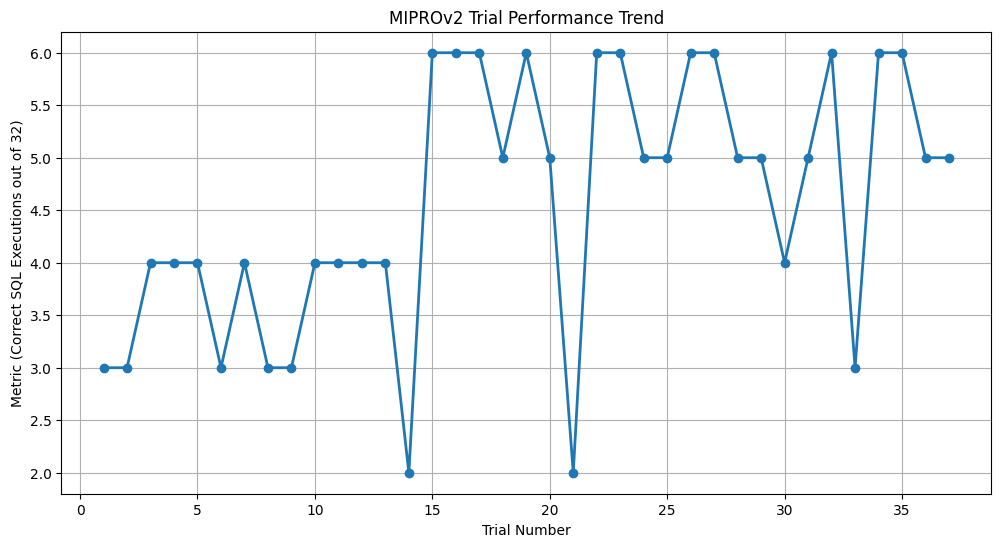

In [5]:
import time
import re
import logging
import matplotlib.pyplot as plt
from dspy.teleprompt import MIPROv2
from dspy.evaluate import Evaluate

# ===============================
# 1) Trial Metric 로그 수집 세팅
# ===============================

trial_metrics = []

class MetricLogHandler(logging.Handler):
    def emit(self, record):
        msg = record.getMessage()

        # 패턴 예시:
        # "Average Metric: 3 / 32 (9.4%)"
        match = re.search(r"Average Metric:\s*([0-9.]+)\s*/\s*32", msg)
        if match:
            val = float(match.group(1))
            trial_metrics.append(val)

logger = logging.getLogger("dspy")
logger.setLevel(logging.INFO)
logger.addHandler(MetricLogHandler())

# ===============================
# 2) 네 원래 코드 – 그대로 삽입
# ===============================

dspy.settings.num_threads = 8

optimizer = MIPROv2(
    metric=sql_execution_metric,
    auto=None,
    num_candidates=4,
    max_bootstrapped_demos=4,
    max_labeled_demos=4,
    verbose=True,
    num_threads=8
)

start_time = time.time()

optimized_module = optimizer.compile(
    module,
    trainset=train_examples[32:],
    valset=train_examples[:32],
    num_trials=30,
    minibatch=True,
    minibatch_size=32,
)

end_time = time.time()
optimization_duration = end_time - start_time
print(f"\nOptimization took: {optimization_duration:.2f} seconds")

for name, pred in optimized_module.named_predictors():
    print(f"\n=== Predictor: {name} ===")
    try:
        instruction = pred.signature.instructions.strip()
        print(">> Final Instruction:\n", instruction)
        if hasattr(dspy.settings, 'lm') and hasattr(dspy.settings.lm, 'token_len'):
            token_count = dspy.settings.lm.token_len(instruction)
            print(f">> Instruction Token Count: {token_count}")
        else:
            print(">> Token count not available.")
    except AttributeError:
        pass

    if hasattr(pred, "demos") and pred.demos:
        print(">> Few-shot Demos:")
        for i, d in enumerate(pred.demos, 1):
            print(f"  [Demo {i}] Q: {getattr(d, 'question', None)}")
            print(f"           SQL: {getattr(d, 'sql', None)}\n")

optimized_evaluator = Evaluate(
    devset=test_examples,
    metric=sql_execution_metric,
    num_threads=4,
    display_progress=True
)

# ===============================
# 3) Trial Metric 그래프 그리기
# ===============================

plt.figure(figsize=(12, 6))
plt.plot(range(1, len(trial_metrics) + 1),
         trial_metrics,
         marker='o',
         linestyle='-',
         linewidth=2)

plt.title("MIPROv2 Trial Performance Trend")
plt.xlabel("Trial Number")
plt.ylabel("Metric (Correct SQL Executions out of 32)")
plt.grid(True)
plt.show()


In [6]:
print("\n[Optimized] Evaluating optimized module...")
optimized_result = optimized_evaluator(optimized_module)


[Optimized] Evaluating optimized module...


Average Metric: 8.00 / 47 (17.0%): 100%|██████████| 47/47 [00:06<00:00,  7.83it/s]

2025/12/01 19:44:59 INFO dspy.evaluate.evaluate: Average Metric: 8 / 47 (17.0%)


In [7]:
print(f"[Optimized] Test Accuracy: {optimized_result.score:.2f}")

[Optimized] Test Accuracy: 17.02


In [8]:
def reconstruct_prompt(pred):
    sig = pred.signature
    instruction = sig.instructions.strip() if hasattr(sig, "instructions") else ""

    prompt = "### Instruction\n" + instruction + "\n\n"

    if hasattr(pred, "demos") and pred.demos:
        prompt += "### Examples\n"
        for i, demo in enumerate(pred.demos, 1):
            q = getattr(demo, "question", None)
            s = getattr(demo, "sql", None)
            prompt += f"[Demo {i}]\nQ: {q}\nSQL: {s}\n\n"

    return prompt.strip()

In [9]:
for name, pred in optimized_module.named_predictors():
    print(f"\n=== Predictor: {name} ===")
    full_prompt = reconstruct_prompt(pred)
    print(full_prompt)


=== Predictor: predict ===
### Instruction
You are a seasoned data analyst specializing in sports databases, particularly Formula 1 and football/soccer analytics. Your expertise lies in translating complex natural language questions into precise, production-grade SQLite queries that leverage multi-hop joins, temporal filtering, and domain-specific semantics. Given a database schema and a natural language question, first reason step-by-step to identify the relevant tables, columns, relationships, and business logic—then generate a clean, executable SQL query that handles edge cases like nulls, type consistency, and aggregation correctly. Return only the SQL query, formatted for direct execution.

### Examples
[Demo 1]
Q: What is the difference of the average ball control score between Abdou Diallo and Aaron Appindangoye
?
SQL: SELECT ABS(
    (SELECT AVG(pa1.ball_control) 
     FROM Player p1 
     JOIN Player_Attributes pa1 ON p1.player_api_id = pa1.player_api_id 
     WHERE p1.player

In [10]:
import tiktoken
encoding = tiktoken.get_encoding("cl100k_base")
token_count = len(encoding.encode(full_prompt))
print(f"Final Prompt Token Count: {token_count}")

Final Prompt Token Count: 586
